<a href="https://colab.research.google.com/github/YuvanBharathi13/DeepLearning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2025-06-20 17:04:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2025-06-20 17:04:38 (159 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
def unzip(zip_link):
  zip_ref = zipfile.ZipFile(zip_link)
  zip_ref.extractall()
  zip_ref.close()

#Pre processing data

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dir_name, files in os.walk(dir_path):
    print(f"There are {len(dir_name)} folders, {len(files)} files in {dirpath}")

In [5]:
walk_through_dir('10_food_classes_10_percent')

There are 2 folders, 0 files in 10_food_classes_10_percent
There are 10 folders, 0 files in 10_food_classes_10_percent/test
There are 0 folders, 250 files in 10_food_classes_10_percent/test/ramen
There are 0 folders, 250 files in 10_food_classes_10_percent/test/ice_cream
There are 0 folders, 250 files in 10_food_classes_10_percent/test/hamburger
There are 0 folders, 250 files in 10_food_classes_10_percent/test/steak
There are 0 folders, 250 files in 10_food_classes_10_percent/test/grilled_salmon
There are 0 folders, 250 files in 10_food_classes_10_percent/test/fried_rice
There are 0 folders, 250 files in 10_food_classes_10_percent/test/chicken_wings
There are 0 folders, 250 files in 10_food_classes_10_percent/test/sushi
There are 0 folders, 250 files in 10_food_classes_10_percent/test/chicken_curry
There are 0 folders, 250 files in 10_food_classes_10_percent/test/pizza
There are 10 folders, 0 files in 10_food_classes_10_percent/train
There are 0 folders, 75 files in 10_food_classes_10_

In [6]:
import pathlib
def get_class_names(train_path):
  data_dir = pathlib.Path(train_path)
  class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
  return class_names

In [7]:
get_class_names('10_food_classes_10_percent/test')

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [8]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

- instead of using ImageDataGenerator, this time we will be using tf.keras.preprocessing.image_dataset_from_directory(), which returns a tf.data.Dataset object.
- This type of dataset is faster than ImageDataGeberator API and comes with multiple functions.

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224,224),
                                                                 batch_size=32,
                                                                 label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224,224),
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

- below we can see that the values of images are not scaled and the labels are all ONE HOT ENCODED.
- there is no need to scale the images now as most models have a scale layer within them that does the job.(resnet doesnt have)

In [11]:
for images, labels in train_data.take(1):
  print(images)
  print(labels)

tf.Tensor(
[[[[139.5        123.35715     62.571426  ]
   [135.99489    107.7551      52.520405  ]
   [139.7857     101.63775     51.0102    ]
   ...
   [205.71948     85.71949    132.14801   ]
   [203.45413     82.31126    127.239815  ]
   [217.79079     91.24995    134.84685   ]]

  [[144.55612    115.984695    63.34184   ]
   [104.24999     67.68366     23.244888  ]
   [ 96.591835    56.566322    19.97959   ]
   ...
   [184.38266     68.29592    113.73975   ]
   [185.29086     61.948956   108.07143   ]
   [203.82687     71.63806    119.760445  ]]

  [[132.0408      95.46938     53.61224   ]
   [ 96.28061     58.392853    27.637754  ]
   [ 83.69387     47.65306     26.030611  ]
   ...
   [172.72925     60.50982    104.67815   ]
   [173.78061     50.20908     97.4234    ]
   [179.09729     42.15332     92.587036  ]]

  ...

  [[ 85.43889     58.591938    28.796034  ]
   [ 95.97958     63.122437    28.40815   ]
   [105.07141     70.49994     30.285671  ]
   ...
   [220.47966    244.336

# Creating models

## Model 0

In [12]:
# create the base model(trained) from tf.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freeze the weights
base_model.trainable = False

# create the input layer with input shape as (224,224,3)
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# suppose you are using resnet which does not have a scaling layer we must scale it
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# pass the output of the input layer to the base_model
x = base_model(inputs)

# pass the ouput pf the base_model to the average pooling layer which
# aggregates most important information and reduces number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# pass the output of the average layer to the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# create the model using the inputs and outputs layers
model_0 = tf.keras.Model(inputs,outputs)

In [13]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [14]:
zero_history = model_0.fit(train_data,
                           epochs=5,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=len(test_data))

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.2570 - loss: 2.1269 - val_accuracy: 0.7240 - val_loss: 1.3458
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.7303 - loss: 1.2486 - val_accuracy: 0.8084 - val_loss: 0.9027
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.8178 - loss: 0.8728 - val_accuracy: 0.8376 - val_loss: 0.7237
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.8634 - loss: 0.6976 - val_accuracy: 0.8524 - val_loss: 0.6267
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.8571 - loss: 0.6035 - val_accuracy: 0.8560 - val_loss: 0.5728


In [15]:
def plot_curves(history):
  loss_train = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)

  plt.plot(epochs,loss_train,'r',label='Training Loss')
  plt.plot(epochs,val_loss,'b',label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)

  plt.plot(epochs,accuracy,'r',label='Training Accuracy')
  plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

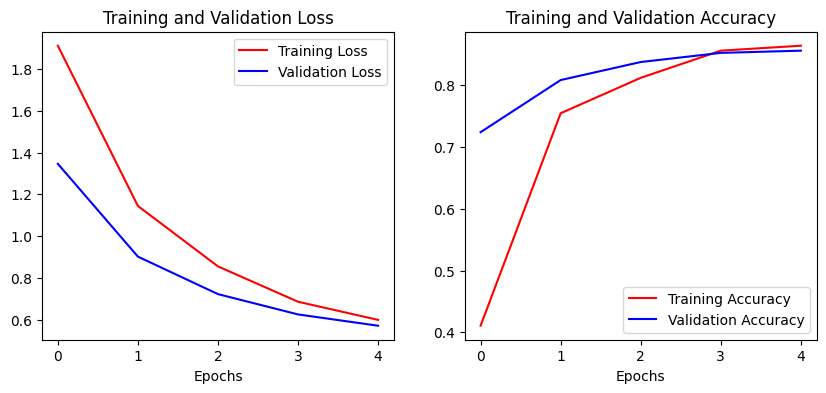

In [16]:
plot_curves(zero_history)

### understanding globalaveragepooling2d

In [17]:
shape = (1,4,4,3)

tf.random.set_seed(42)

tensor = tf.random.normal(shape)
print(f"Sample output of the pre-trained model - {tensor}")

global_average_pool_layer_output = tf.keras.layers.GlobalAveragePooling2D()(tensor)
print(f"Output of the global average pooling layer - {global_average_pool_layer_output}")

tensor.shape, global_average_pool_layer_output.shape

Sample output of the pre-trained model - [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Output of the global average pooling layer - [[-0.09368646 -0.45840448 -0.2885598 ]]


(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))

In [18]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

- The convolutional layers of the model (which are pretrained on ImageNet) extract `features` which are learned patterns the model uses to differentiate between classes like edges, textures and shapes.
- After the convolutional layers, a GlobalAveragePooling2D layer is applied. This layer collapses the 4D spatial dimensions of the final convolutional feature maps into a 2D vector for EfficientNetB0.
- The result is a feature vector which is a numeric vector that captures abstract high-level information about the input image.

## Model 1

- this is going to be a feature extraction transfer learning model trained on 1 percent of the 10 class food data with data augmentation
- only the training data is going to change and not the testing data as we want that to be common among all models.

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2025-06-20 17:06:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   146MB/s    in 0.9s    

2025-06-20 17:06:45 (146 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [20]:
unzip('10_food_classes_1_percent.zip')

In [21]:
walk_through_dir('10_food_classes_1_percent')

There are 2 folders, 0 files in 10_food_classes_1_percent
There are 10 folders, 0 files in 10_food_classes_1_percent/test
There are 0 folders, 250 files in 10_food_classes_1_percent/test/ramen
There are 0 folders, 250 files in 10_food_classes_1_percent/test/ice_cream
There are 0 folders, 250 files in 10_food_classes_1_percent/test/hamburger
There are 0 folders, 250 files in 10_food_classes_1_percent/test/steak
There are 0 folders, 250 files in 10_food_classes_1_percent/test/grilled_salmon
There are 0 folders, 250 files in 10_food_classes_1_percent/test/fried_rice
There are 0 folders, 250 files in 10_food_classes_1_percent/test/chicken_wings
There are 0 folders, 250 files in 10_food_classes_1_percent/test/sushi
There are 0 folders, 250 files in 10_food_classes_1_percent/test/chicken_curry
There are 0 folders, 250 files in 10_food_classes_1_percent/test/pizza
There are 10 folders, 0 files in 10_food_classes_1_percent/train
There are 0 folders, 7 files in 10_food_classes_1_percent/train/r

In [22]:
get_class_names('10_food_classes_1_percent/train')

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [23]:
train_dir = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [24]:
one_percent_train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           batch_size=32,
                                                                           image_size=(224,224),
                                                                           label_mode='categorical')
one_percent_test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          image_size=(224,224),
                                                                          label_mode='categorical',
                                                                          batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### data augmentation keras layer

- Now we are going to augment the training data. we are going to add all the types of augmentations suchs as zoom, rotate and more as part of one sequential model.
- then we are going to add this layer into our final model.
- doing data augmentation through this way uses the GPU while doing it through ImageDataGenerator uses the CPU slowing the runtime
- the augmentation layer added will only work when the model is training and during testing or predictions it becomes dormant.

In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(224,224,3)),
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

### viewing the augmented data

In [26]:
import matplotlib.image as mpimg
import random

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

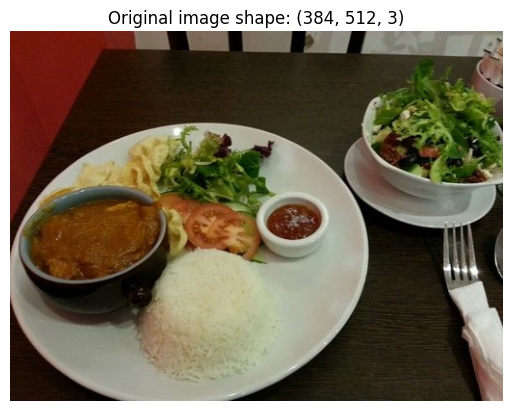

In [27]:
random_class = random.choice(one_percent_train_data.class_names)
target_dir = '10_food_classes_1_percent/train/'+ random_class
image_file = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + image_file
image = mpimg.imread(random_image_path)
plt.imshow(image)
plt.title(f"Original image shape: {image.shape}")
plt.axis(False)

- we have pass a 4 dimensional image to the data augmentation model as it excpects batch size so we use `tf.expand_dims()`
- after data is augmentated it wont be in integer but in float type.
- for `imshow` to display an image if it is in float the values must range from 0-1. and we must squeeze it it 3 dimensions as well

(np.float64(-0.5), np.float64(608.5), np.float64(403.5), np.float64(-0.5))

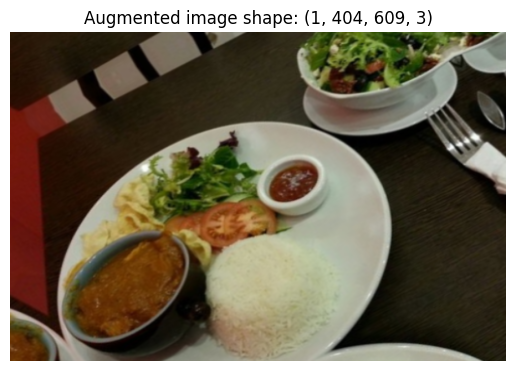

In [28]:
augmented_image = data_augmentation(tf.expand_dims(image,axis=0))
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented image shape: {augmented_image.shape}")
plt.axis(False)

### creating model 1

In [29]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

model_1 = tf.keras.Model(inputs,outputs)

In [30]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [31]:
model_1_history = model_1.fit(one_percent_train_data,
                               epochs=5,
                               steps_per_epoch=len(one_percent_train_data),
                               validation_data=one_percent_test_data,
                               validation_steps=len(one_percent_test_data))

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.0975 - loss: 2.3716 - val_accuracy: 0.2328 - val_loss: 2.1651
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2165 - loss: 2.2031 - val_accuracy: 0.3168 - val_loss: 2.0625
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.2379 - loss: 2.0243 - val_accuracy: 0.3820 - val_loss: 1.9742
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4954 - loss: 1.8473 - val_accuracy: 0.4340 - val_loss: 1.8957
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4740 - loss: 1.7726 - val_accuracy: 0.4808 - val_loss: 1.8214


`which just 7 images per class we were able to achieve 50% accuracy. crazzzyyyy`

In [32]:
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [33]:
model_1.evaluate(one_percent_test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.4632 - loss: 1.8284


[1.8214191198349, 0.48080000281333923]

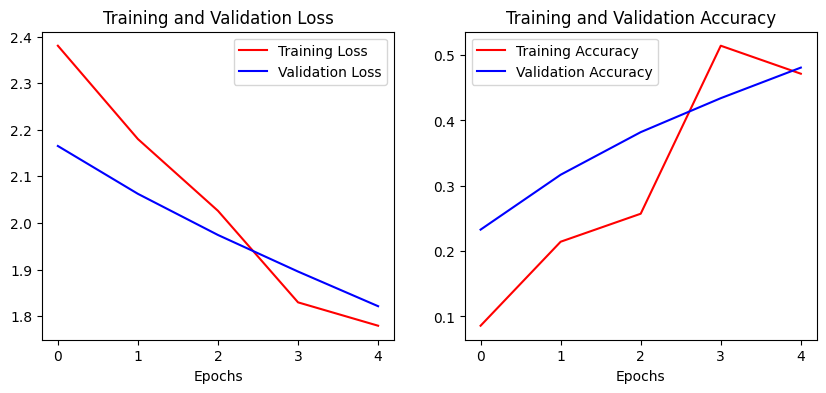

In [34]:
plot_curves(model_1_history)

## Model 2

This model is going to be the same as Model 1 with augmentation but it will now be trained on 10 percent of the data wrather than 1 percent.

In [35]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [36]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            batch_size=32,
                                                                            label_mode='categorical',
                                                                            image_size=(224,224))
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           batch_size=32,
                                                                           image_size=(224,224),
                                                                           label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [37]:
data_augmentation_10_percent = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
],name='data_augmentation_layer')

### creating model 2

In [38]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name="Input_layer")
x = data_augmentation_10_percent(inputs)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

model_2 = tf.keras.Model(inputs,outputs)

In [39]:
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [40]:
model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

- so apparently if you want to save the model the file path has to end with .keras
- and if you want to save just the weights and dont want others to see your architecture use the following ending  '/tmp/ckpt/checkpoint.weights.h5' . has to end with weights.h5 basically

In [41]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints/model_2.keras" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=False, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [42]:
model_2_history = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=len(test_data_10_percent),
                              callbacks=[checkpoint_callback])

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.1656 - loss: 2.2924
Epoch 1: val_loss improved from inf to 1.60456, saving model to ten_percent_model_checkpoints/model_2.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 706ms/step - accuracy: 0.1702 - loss: 2.2842 - val_accuracy: 0.5936 - val_loss: 1.6046
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.6035 - loss: 1.5713
Epoch 2: val_loss improved from 1.60456 to 1.14478, saving model to ten_percent_model_checkpoints/model_2.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 554ms/step - accuracy: 0.6045 - loss: 1.5678 - val_accuracy: 0.7524 - val_loss: 1.1448
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7298 - loss: 1.2093
Epoch 3: val_loss improved from 1.14478 to 0.90072, saving model to ten_percent_model_checkpoints/model_2.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 554ms/step - accuracy: 0.7289 - loss: 1.2087 - val_accuracy: 0.7980 - val_loss: 0.9007
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accura

- if you look at it model 1 and model 2 are trained on the same data but model 2 has the data augmentation layer.
- from training the two of them, it looks like model 0 is performing better
- find out why ?

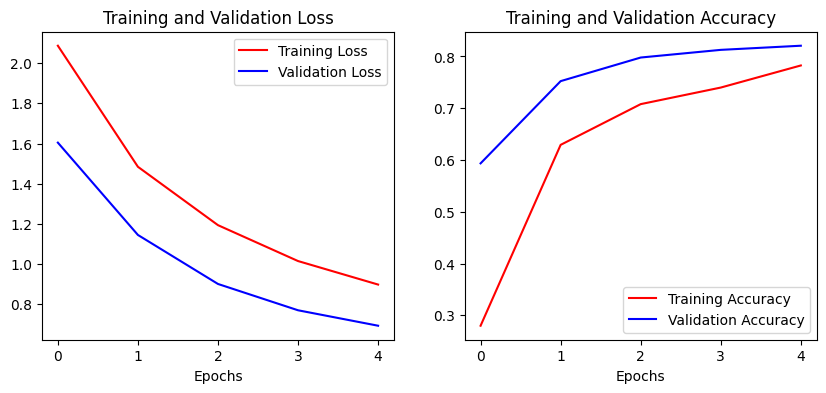

In [43]:
plot_curves(model_2_history) # sexy curves, almost the same shape. i think if we train a bit longer it will beat model 0
# since the data is augmented it is needing more epochs to get better.

In [44]:
### loading the save best model
model_2_loaded = tf.keras.models.load_model('/content/ten_percent_model_checkpoints/model_2.keras')

In [45]:
model_2.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8239 - loss: 0.6876


[0.6927922964096069, 0.8208000063896179]

In [46]:
model_2_loaded.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8260 - loss: 0.6799


[0.6927922964096069, 0.8208000063896179]

## Model 3

- Same as model 2 but now the final 10 layers are going to be unfrozen and fine tuned.
- we usually unfreeze the lower layers in a model while fine tuning as the higher layers learn larger features such as shape the lower layers learn more detailed features, so thats why we try to train the lower layers on our very own data so that it is more customized to our problems details.
- so we first build aand train a feature extraction model with our custom output layer and then unfreeze some of the layers before the output layer to be fine tuned.

In [47]:
model_2.layers

[<InputLayer name=Input_layer, built=True>,
 <Sequential name=data_augmentation_layer, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [48]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<InputLayer name=Input_layer, built=True> True
<Sequential name=data_augmentation_layer, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [49]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_layer_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [50]:
print(len(model_2.layers[2].trainable_variables)) # this tells us all the weights are frozen

0


- while fine tuning the 10 unfrozen layers it is best to lower the learning rate to prevent overfitting

In [51]:
# lets unfreeze the last 10 layers in our layer 2
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

In [52]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable) # check and you will notice that the last 10 layers trainable is True

0 input_layer_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [53]:
print(len(base_model.trainable_variables))

10


In [54]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints/model_3.keras" # note: remember saving directly to Colab is temporary

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=False, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

- `my-view` : the reason the output layer is trained more than the unfrozen basemodel layers cause we are adding random weights at the beginning so it take more time to get the correct weights.
- the other layers on the other hand have weights which were already from a trained model and they dont need as much epochs as the output layer

In [55]:
model_3_history = model_2.fit(train_data_10_percent,
                              epochs=10,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              initial_epoch = model_2_history.epoch[-1], # it is added so that we have data for all epochs and the previous epoch data are not overidden
                              validation_steps=len(test_data_10_percent),
                              callbacks=[checkpoint_callback])

Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7400 - loss: 0.9488
Epoch 5: val_loss improved from inf to 0.45137, saving model to ten_percent_model_checkpoints/model_3.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 683ms/step - accuracy: 0.7408 - loss: 0.9459 - val_accuracy: 0.8516 - val_loss: 0.4514
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8487 - loss: 0.5299
Epoch 6: val_loss improved from 0.45137 to 0.38905, saving model to ten_percent_model_checkpoints/model_3.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 521ms/step - accuracy: 0.8483 - loss: 0.5302 - val_accuracy: 0.8688 - val_loss: 0.3891
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8710 - loss: 0.4181
Epoch 7: val_loss improved from 0.38905 to 0.38314, saving model to ten_percent_model_checkpoints/model_3.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step - accuracy: 0.8708 - loss: 0.4192 - val_accuracy: 0.8752 - val_loss: 0.3831
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - ac

In [56]:
model_2_loaded.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8292 - loss: 0.6856


[0.6927924156188965, 0.8208000063896179]

In [57]:
model_2.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9026 - loss: 0.3136


[0.34392911195755005, 0.8952000141143799]

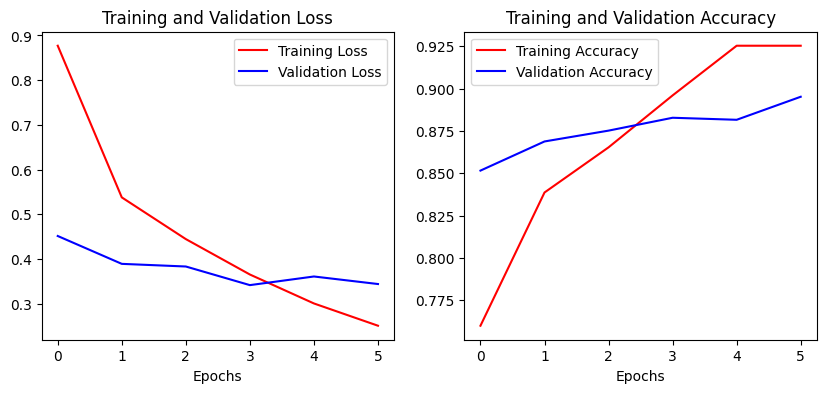

In [58]:
plot_curves(model_3_history) # this only shows from epoch 6 to 10.

In [59]:
# creating a function that will allow us to plot all 10 epochs
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.2800000011920929, 0.6293333172798157, 0.7080000042915344, 0.7400000095367432, 0.7826666831970215, 0.7599999904632568, 0.8386666774749756, 0.8653333187103271, 0.8960000276565552, 0.9253333210945129, 0.9253333210945129]


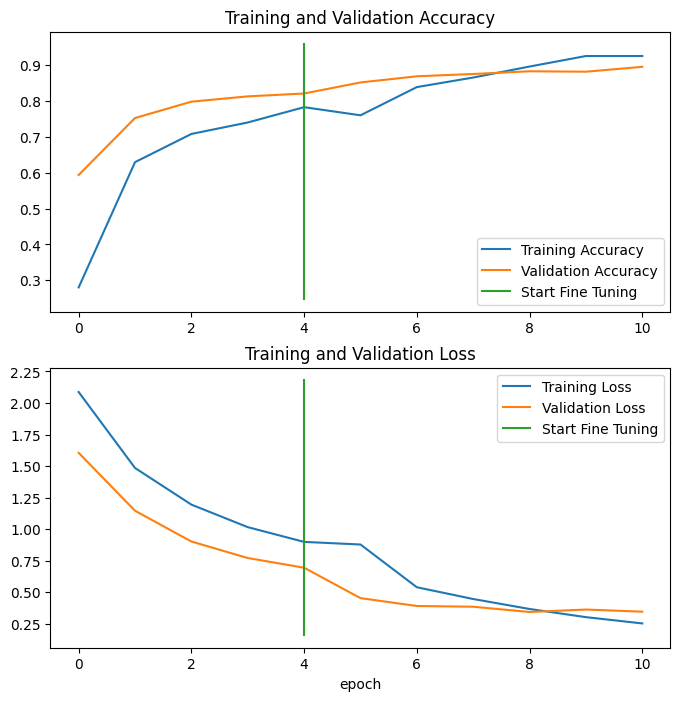

In [60]:
compare_historys(model_2_history,model_3_history)

## Model 4

- trained with 100 percent data

In [61]:
model_3_loaded = tf.keras.models.load_model('/content/ten_percent_model_checkpoints/model_3.keras')

In [62]:
# reverting model_2 to the weights before fine tuning was done
model_2.load_weights('/content/ten_percent_model_checkpoints/model_2.keras')
model_2.evaluate(test_data_10_percent)

 1/79 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.8750 - loss: 0.6627

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8286 - loss: 0.6849


[0.6927923560142517, 0.8208000063896179]

In [63]:
model_2_loaded.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8255 - loss: 0.6882


[0.6927923560142517, 0.8208000063896179]

In [64]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip('10_food_classes_all_data.zip')

--2025-06-20 17:12:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  96.3MB/s    in 5.1s    

2025-06-20 17:12:40 (97.3 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [65]:
walk_through_dir('10_food_classes_all_data')

There are 2 folders, 0 files in 10_food_classes_all_data
There are 10 folders, 0 files in 10_food_classes_all_data/test
There are 0 folders, 250 files in 10_food_classes_all_data/test/ramen
There are 0 folders, 250 files in 10_food_classes_all_data/test/ice_cream
There are 0 folders, 250 files in 10_food_classes_all_data/test/hamburger
There are 0 folders, 250 files in 10_food_classes_all_data/test/steak
There are 0 folders, 250 files in 10_food_classes_all_data/test/grilled_salmon
There are 0 folders, 250 files in 10_food_classes_all_data/test/fried_rice
There are 0 folders, 250 files in 10_food_classes_all_data/test/chicken_wings
There are 0 folders, 250 files in 10_food_classes_all_data/test/sushi
There are 0 folders, 250 files in 10_food_classes_all_data/test/chicken_curry
There are 0 folders, 250 files in 10_food_classes_all_data/test/pizza
There are 10 folders, 0 files in 10_food_classes_all_data/train
There are 0 folders, 750 files in 10_food_classes_all_data/train/ramen
There a

In [66]:
get_class_names("10_food_classes_all_data/test")

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [67]:
model_2.layers

[<InputLayer name=Input_layer, built=True>,
 <Sequential name=data_augmentation_layer, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

- the the last layers are still trainable but the weights have been changed to model 2's weights

In [68]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_layer_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [69]:
train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [70]:
train_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     batch_size=32,
                                                                     image_size=(224,224),
                                                                     label_mode ='categorical')
test_all_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                     batch_size=32,
                                                                     image_size=(224,224),
                                                                     label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [71]:
# when ever you have made a change to your model you must compile it again
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

In [72]:
model_4_history = model_2.fit(train_all_data,
                              epochs=10,
                              steps_per_epoch=len(train_all_data),
                              validation_data=test_all_data,
                              validation_steps=len(test_all_data),
                              initial_epoch = model_2_history.epoch[-1])

Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 277ms/step - accuracy: 0.7631 - loss: 0.7751 - val_accuracy: 0.8968 - val_loss: 0.3058
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 55s 232ms/step - accuracy: 0.8358 - loss: 0.5180 - val_accuracy: 0.9168 - val_loss: 0.2478
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 49s 209ms/step - accuracy: 0.8566 - loss: 0.4336 - val_accuracy: 0.9176 - val_loss: 0.2388
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 78s 191ms/step - accuracy: 0.8752 - loss: 0.4013 - val_accuracy: 0.9256 - val_loss: 0.2179
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 191ms/step - accuracy: 0.8910 - loss: 0.3395 - val_accuracy: 0.9284 - val_loss: 0.2121
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 78s 177ms/step - accuracy: 0.8978 - loss: 0.3146 - val_accuracy: 0.9260 - val_loss: 0.2240


In [73]:
model_2.evaluate(test_all_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9293 - loss: 0.2159


[0.22399157285690308, 0.9259999990463257]

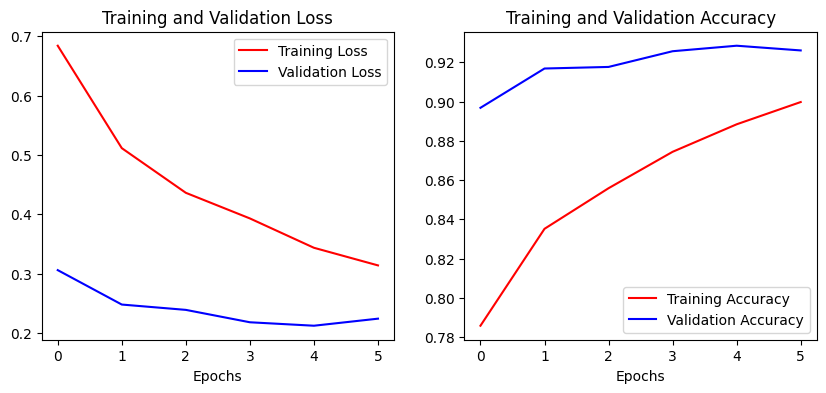

In [74]:
plot_curves(model_4_history)

5
11
[0.2800000011920929, 0.6293333172798157, 0.7080000042915344, 0.7400000095367432, 0.7826666831970215, 0.7858666777610779, 0.8352000117301941, 0.8558666706085205, 0.8744000196456909, 0.8884000182151794, 0.899733304977417]


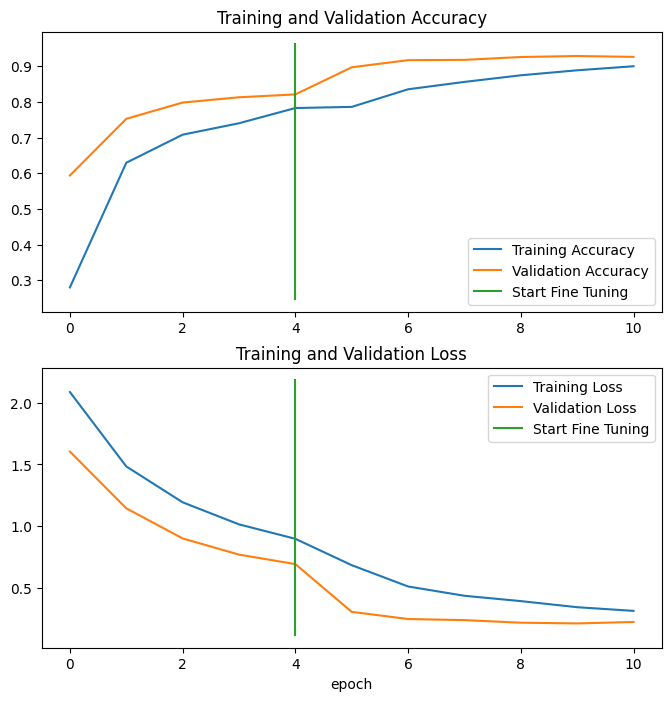

In [75]:
compare_historys(model_2_history,model_4_history) # you can see that if we train for more epochs we can improve it a bit more

## BOI BOI